## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def calculateMAE(test, forecasts):
    mae = mean_absolute_error(test, forecasts)
    return mae

def calculateMAPE(test, forecasts):
    percentage_errors = [abs((actual - predicted) / actual) * 100 for actual, predicted in zip(test, forecasts) if actual != 0]
    mape = sum(percentage_errors) / len(percentage_errors)
    return mape

def calculateMSE(test, forecasts):
    mse = mean_squared_error(test, forecasts)
    return mse

def calculateRMSE(test, forecasts):
    mse = mean_squared_error(test, forecasts)
    rmse = sqrt(mse)
    return rmse

In [3]:
df = pd.read_excel("EUNG.xlsx")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df

,EUNG,EUNG_LAG,Equity Market Volatility,Economic Policy Uncertainty Europe,NY Business Conditions,3 Month Treasury Bill,Infectious Disease Tracker,Nickel,COV19,RUWAR
DATE,,,,,,,,,,
2001-10-01,-0.154151,0.000000,22.46,141.35,-4.5,-0.72,0.39,-0.088497,0,0
2001-11-01,0.000000,-0.154151,-13.09,-10.39,-2.2,-0.48,-0.06,-0.045894,0,0
2001-12-01,-0.006192,0.000000,-2.94,-39.39,-6.8,-0.29,0.09,0.060355,0,0
2002-01-01,-0.143340,-0.006192,-2.04,-53.76,11.7,-0.18,-0.39,0.035324,0,0
2002-02-01,0.000000,-0.143340,4.29,-5.87,11.2,-0.04,0.29,0.131247,0,0
...,...,...,...,...,...,...,...,...,...,...
2023-06-01,0.031592,-0.316354,2.93,21.28,-42.6,0.22,2.32,-0.071308,1,1
2023-07-01,-0.068368,0.031592,-5.14,-18.30,38.4,0.02,-2.45,-0.041580,1,1
2023-08-01,0.109307,-0.068368,-0.72,16.36,-5.5,0.09,-0.81,-0.006711,1,1


In [4]:
y = df['EUNG']
X = df[["EUNG_LAG","Equity Market Volatility","Economic Policy Uncertainty Europe","NY Business Conditions","3 Month Treasury Bill","Infectious Disease Tracker","Nickel","COV19","RUWAR"]]

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                   EUNG   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.990
Date:                Sat, 13 Jan 2024   Prob (F-statistic):             0.0409
Time:                        14:18:00   Log-Likelihood:                 157.67
No. Observations:                 265   AIC:                            -295.3
Df Residuals:                     255   BIC:                            -259.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [5]:
selected_columns = ["EUNG","EUNG_LAG","COV19","RUWAR"]
pruned_df = df[selected_columns]

pruned_df = pruned_df.set_index(df.index)
pruned_df

,EUNG,EUNG_LAG,COV19,RUWAR
DATE,,,,
2001-10-01,-0.154151,0.000000,0,0
2001-11-01,0.000000,-0.154151,0,0
2001-12-01,-0.006192,0.000000,0,0
2002-01-01,-0.143340,-0.006192,0,0
2002-02-01,0.000000,-0.143340,0,0
...,...,...,...,...
2023-06-01,0.031592,-0.316354,1,1
2023-07-01,-0.068368,0.031592,1,1
2023-08-01,0.109307,-0.068368,1,1


In [6]:
# Separating the dependent variable
y = pruned_df.iloc[:, 0].values.reshape(-1, 1)
X = pruned_df.iloc[:, 1:].values

# Scaling only the dependent variable
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], 1, X.shape[1])

# Manually splitting data into train and test sets without shuffling
split_index = int(0.91 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

In [7]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(units=3, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units=90, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=270, return_sequences=True))
model.add(Dropout(0.6))

model.add(LSTM(units=270, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.1))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, y_train, epochs=300, batch_size=6, verbose=0)#4 0.26

In [8]:
# Making predictions
predictions = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


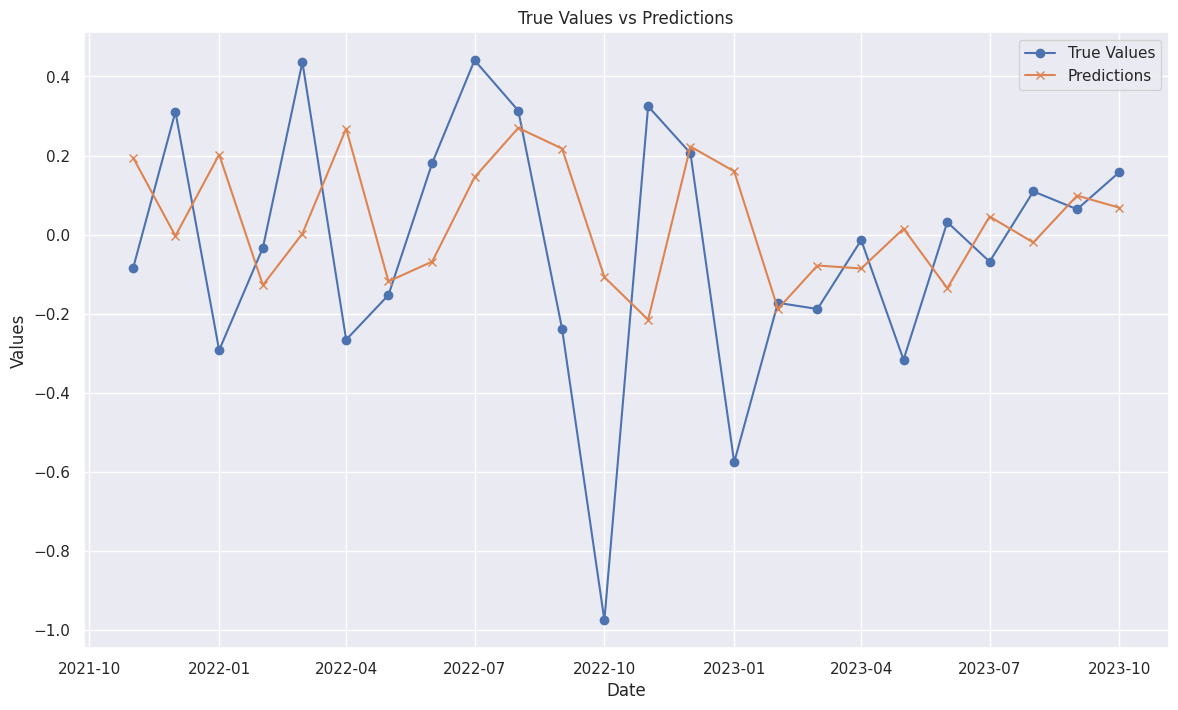

In [9]:
# Inverting the scaling for y_test and predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()


# Plotting the true values and the predictions
plt.figure(figsize=(14, 8))
test_dates = df.index[len(pruned_df) - len(y_test):]
plt.plot(test_dates, y_test, label='True Values', marker='o')
plt.plot(test_dates, predictions, label='Predictions',  marker='x')
plt.title('True Values vs Predictions')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [10]:
print(f"MAE: {calculateMAE(y_test, predictions):.4f}")
print(f"MAPE: {calculateMAPE(y_test, predictions):.4f} %")
print(f"MSE: {calculateMSE(y_test, predictions):.4f}")
print(f"RMSE: {calculateRMSE(y_test, predictions):.4f}")

MAE: 0.2689
MAPE: 151.1213 %
MSE: 0.1268
RMSE: 0.3561


## Saving Predictions

In [11]:
df = pd.DataFrame({'EUNG M LSTM': predictions, 'Actual': y_test})
df.to_excel("EUNG_M_LSTM_forecast.xlsx", index=True)
df

,EUNG M LSTM,Actual
0,0.194893,-0.085031
1,-0.003285,0.310788
2,0.202453,-0.292332
3,-0.127695,-0.033172
4,0.002499,0.436124
5,0.268150,-0.265797
6,-0.118302,-0.152693
7,-0.068105,0.181046
8,0.144982,0.440986
9,0.269851,0.313447


In [12]:
# Open a file in write mode
with open('EUNG M LSTM Results.txt', 'w') as file:
    # Write the variables to the file
    file.write(f'{calculateMAE(y_test, predictions):.4f}\n')
    file.write(f'{calculateMAPE(y_test, predictions):.4f}\n')
    file.write(f'{calculateMSE(y_test, predictions):.4f}\n')
    file.write(f'{calculateRMSE(y_test, predictions):.4f}\n')